In [1]:
import numpy as np
import pandas as pd
#!pip install statsmodels
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('../outputs/eci_software_2020_2023.csv', delimiter=";")
df.head()

,iso2_code,language,num_pushers,period,diversity,ubiquity,mcp,eci,pci,density,coi,cog,rca,year
0,AE,ANTLR,0,1,18,17,0,-0.29446,2.335159,0.037316,-0.330396,1.303204,0.0,2020
1,AE,ASP.NET,0,1,18,38,0,-0.29446,0.283921,0.213137,-0.330396,0.156123,0.0,2020
2,AE,Ada,0,1,18,9,0,-0.29446,2.289965,0.026459,-0.330396,0.973394,0.0,2020
3,AE,Apex,0,1,18,7,0,-0.29446,2.001467,0.031454,-0.330396,0.905917,0.0,2020
4,AE,AppleScript,0,1,18,9,0,-0.29446,2.593304,0.023655,-0.330396,1.232115,0.0,2020


In [3]:
# Checks
print(df['year'].unique())
print(df['rca'].describe())

[2020 2021 2022 2023]
count    89839.000000
mean         0.393883
std          1.062066
min          0.000000
25%          0.000000
50%          0.000000
75%          0.635488
max         93.328690
Name: rca, dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
emigration = ['GE','ME','CY','AM','KZ','AE','RS','KZ','LT','EE','UZ']

def rus_emi_other(xx):
    if xx in emigration:
        return 'Top emigration destination'
    elif xx =='RU':
        return 'Russia'
    else:
        return 'Other'

df['is_emi'] = df['iso2_code'].map(rus_emi_other)

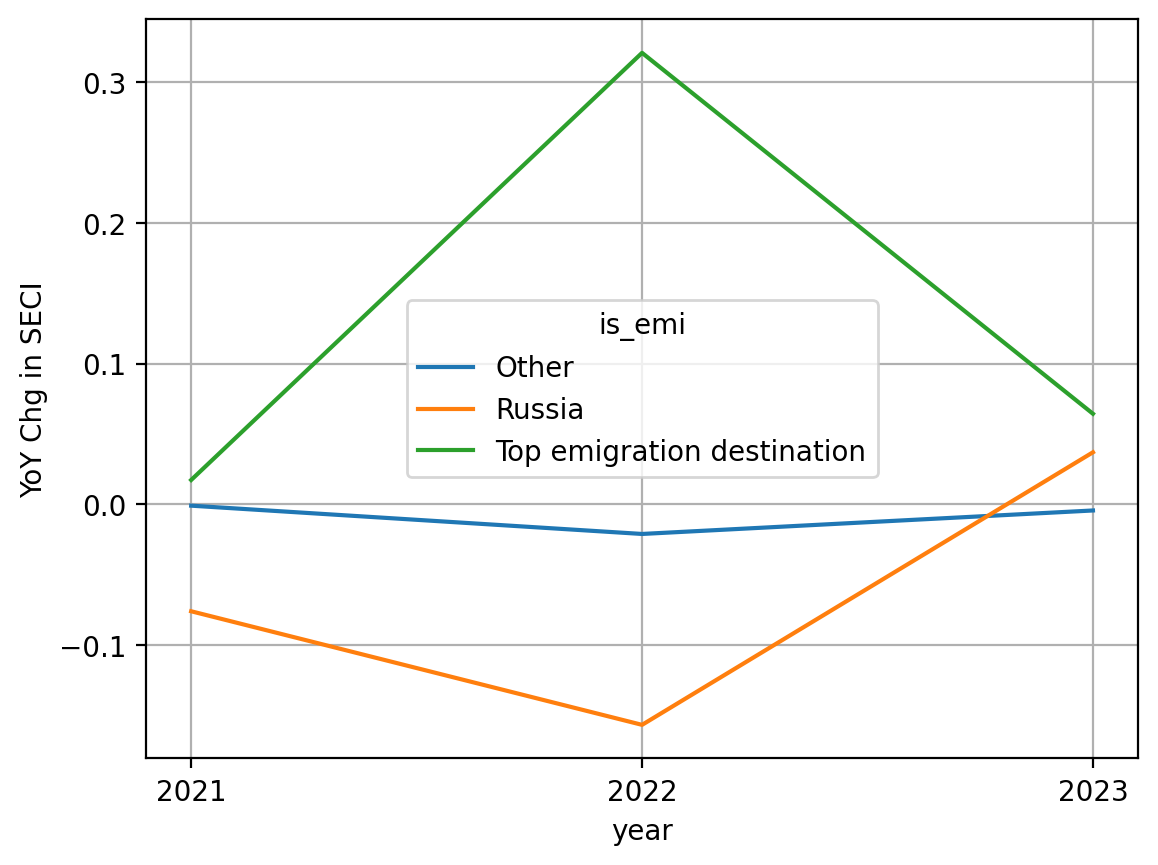

In [6]:
df.groupby(['is_emi','year'])['eci'].mean().unstack(0).diff(1).plot()
plt.xticks([2021,2022,2023])
plt.ylabel('YoY Chg in SECI')
plt.grid()

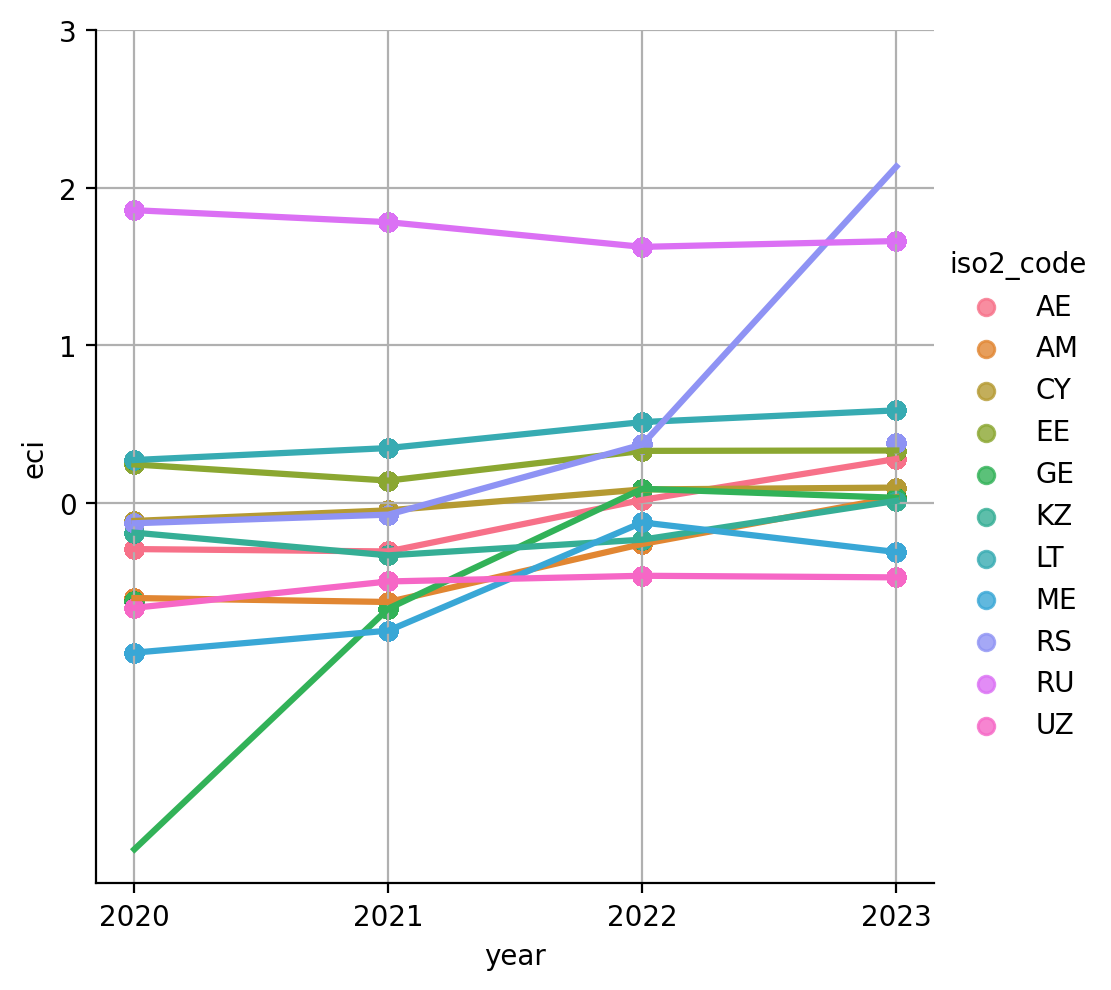

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x='year', y='eci', hue='iso2_code', lowess=True,
           data=df[df['iso2_code'].isin(['RU', 'GE', 'ME', 'CY', 'AM', 'KZ', 'AE', 'RS', 'LT', 'EE', 'UZ'])],
           ci=0)
plt.xticks([2020, 2021, 2022, 2023])
plt.yticks([0, 1, 2, 3])
plt.grid()
plt.show()

# Correlations

In [8]:
# Replicating Jo's results

from scipy.stats import kendalltau
rca_vectors = df.pivot_table(index=['iso2_code', 'year'], columns='language', values='rca', fill_value=0)

def calculate_kendall_tau(russia_rca, other_rca):
    tau, p_value = kendalltau(russia_rca, other_rca)
    return tau, p_value

countries = ['GE', 'ME', 'AM', 'CY']
years = [2020, 2021, 2022, 2023]
results = []

for year in years:
    russia_rca = rca_vectors.loc[('RU', year)]
    for country in countries:
        other_rca = rca_vectors.loc[(country, year)]
        tau, _ = calculate_kendall_tau(russia_rca, other_rca)
        results.append({'year': year, 'pair': f"ru-{country.lower()}", 'kendall_tau': np.round(tau, 3)})

results_kt = pd.DataFrame(results)
results_kt

,year,pair,kendall_tau
0,2020,ru-ge,0.040
1,2020,ru-me,-0.043
2,2020,ru-am,0.041
3,2020,ru-cy,0.006
4,2021,ru-ge,0.062
5,2021,ru-me,-0.030
6,2021,ru-am,0.067
7,2021,ru-cy,0.055
8,2022,ru-ge,0.104
9,2022,ru-me,0.119


# Plot

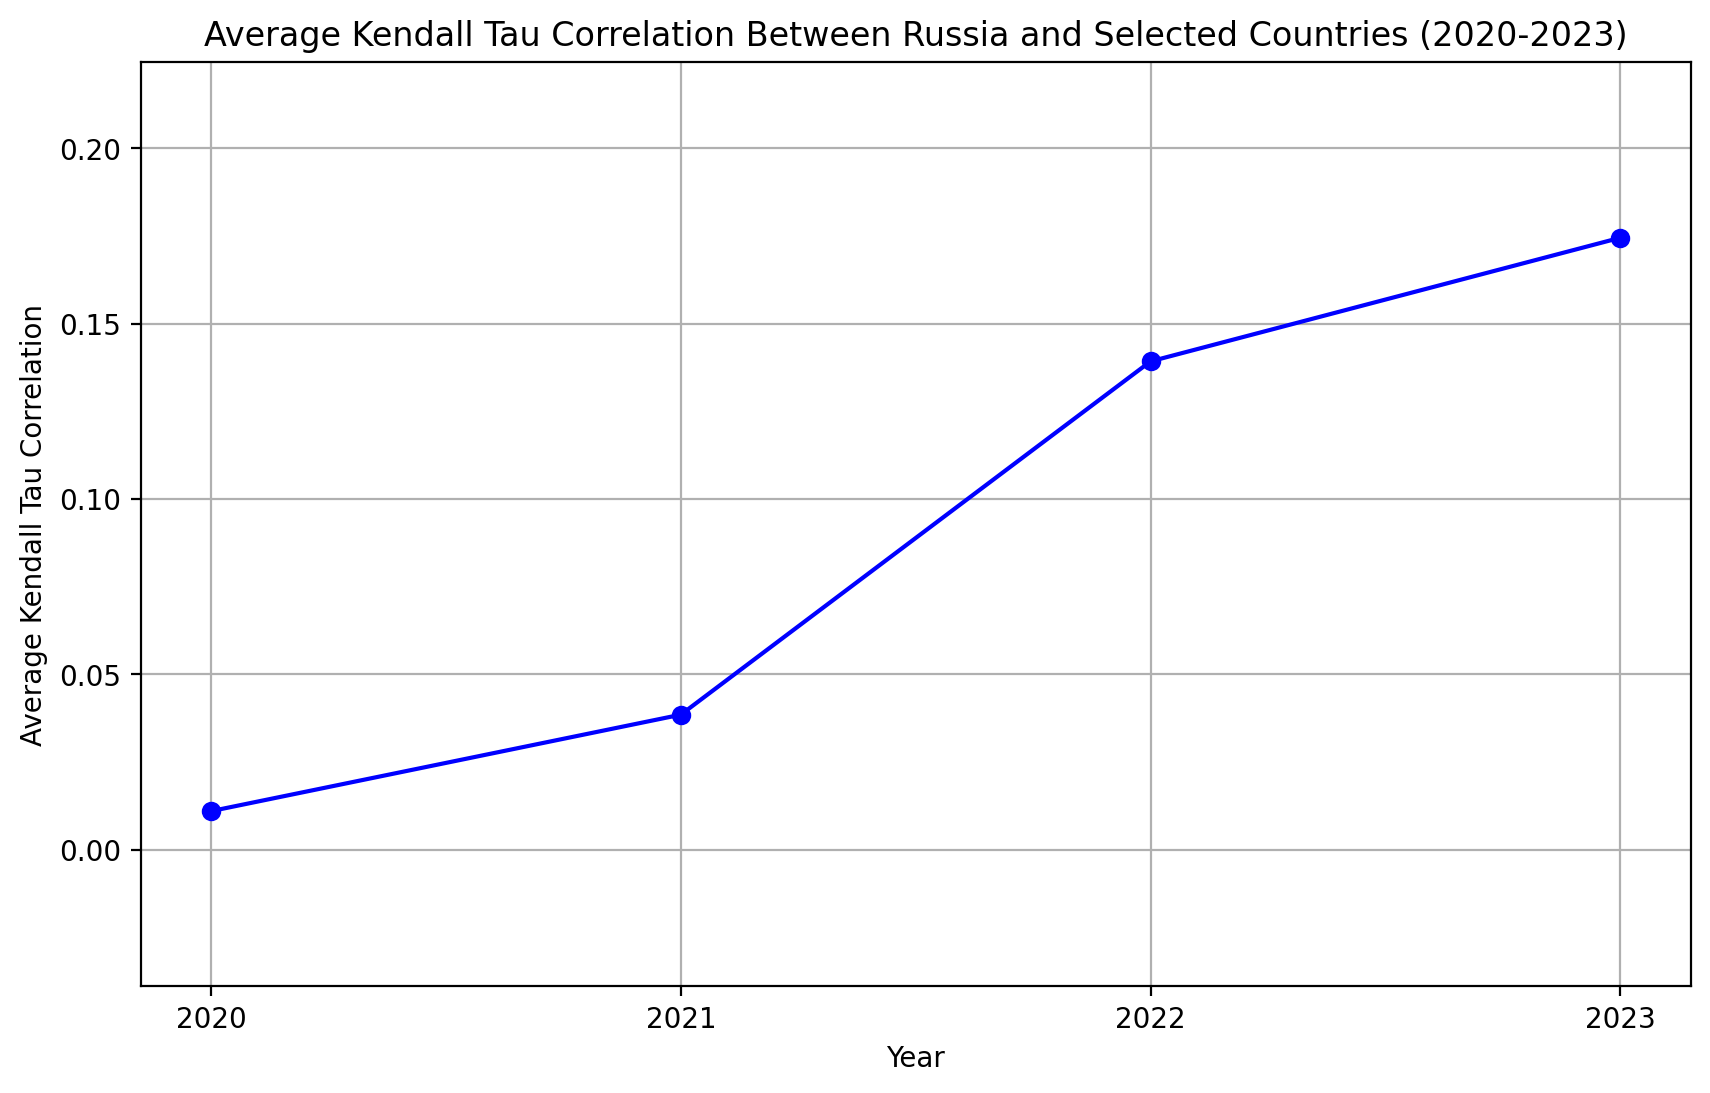

In [9]:
avg_kendall_tau = results_kt.groupby('year')['kendall_tau'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(avg_kendall_tau['year'], avg_kendall_tau['kendall_tau'], marker='o', linestyle='-', color='blue')
plt.title('Average Kendall Tau Correlation Between Russia and Selected Countries (2020-2023)')
plt.xlabel('Year')
plt.ylabel('Average Kendall Tau Correlation')
plt.grid(True)
plt.xticks(avg_kendall_tau['year'])  # Ensure only specific years are marked
plt.ylim(min(avg_kendall_tau['kendall_tau']) - 0.05, max(avg_kendall_tau['kendall_tau']) + 0.05)  # Setting limits for better visualization
plt.show()

# Proximity Control

In [14]:
import pandas as pd
import numpy as np

# Sandor's similarity function
def minimum_conditional_prob(mcp_array1, mcp_array2):
    counter = np.sum(mcp_array1 * mcp_array2)
    denom = max(np.sum(mcp_array1), np.sum(mcp_array2))
    return np.round(counter / denom, 3)

# Transform RCAs into vecs
rca_vectors = df.pivot_table(index=['iso2_code', 'year'], columns='language', values='rca', fill_value=0)
rca_dict = {index: row.values.tolist() for index, row in rca_vectors.iterrows()}

# Find the top 3 Controls
results = []
for country_year, rca_vector in rca_dict.items():
    similarities = []
    for comparison_country_year, comparison_rca_vector in rca_dict.items():
        if country_year != comparison_country_year:
            similarity = minimum_conditional_prob(np.array(rca_vector), np.array(comparison_rca_vector))
            similarities.append((similarity, comparison_country_year))
            
    top_three = sorted(similarities, key=lambda x: x[0], reverse=True)[:3]
    top_three_countries = [x[1] for x in top_three]
    average = df.loc[df.set_index(['iso2_code', 'year']).index.isin(top_three_countries), 'eci'].mean()
    results.append({'iso2_code': country_year[0], 'year': country_year[1], 'proximity_control': average})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df.head(10))

  iso2_code  year  proximity_control
0        AD  2023          -1.356917
1        AE  2020          -0.805998
2        AE  2021          -0.729125
3        AE  2022          -0.715193
4        AE  2023          -0.715193
5        AF  2020          -1.307211
6        AF  2021          -0.894898
7        AF  2022          -0.958766
8        AF  2023          -0.712105
9        AL  2020          -0.602418


In [15]:
results_df.to_csv('../outputs/proximity_control.csv', index=False)